In [1]:
import pandas as pd
import numpy as np
import cProfile
import re
import seaborn as sns
import vaex as vx
import modin.pandas as mpd
import ray
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import polars as pl
import io
import pstats
import matplotlib.pyplot as plt
import time


In [9]:
def profile_read(library_name, read_func):
    pr = cProfile.Profile()
    pr.enable()
    df = read_func()
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    stats_str = s.getvalue()
    lines = stats_str.split('\n')
    for line in lines:
        if 'function calls' in line:
            total_time = ps.total_tt
            break
    return total_time, df

def read_pandas():
    return pd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_modin():
    return mpd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_dask():
    return dd.read_csv('cord_19_embeddings_2022-06-02.csv')

def read_vaex():
    return vx.from_csv('cord_19_embeddings_2022-06-02.csv')

def read_polars():
    return pl.read_csv('cord_19_embeddings_2022-06-02.csv')


In [ ]:
def profile_read_modin():
    start_time = time.time()
    chunks = []
    for chunk in mpd.read_csv('cord_19_embeddings_2022-06-02.csv', chunksize=100000):
        chunks.append(chunk)
    df = mpd.concat(chunks)
    end_time = time.time()
    time_taken = end_time - start_time
    return time_taken, df

times = {}
print("Profiling Modin separately...")
try:
    time_taken, df = profile_read_modin()
    times['modin'] = time_taken
    print(f"Modin: {time_taken:.2f} seconds")
except Exception as e:
    times['modin'] = f'Error: {str(e)}'
    print(f"Modin: Error - {str(e)}")


Profiling Modin separately...
Modin: Error - ray::_deploy_ray_func() (pid=41684, ip=127.0.0.1)
  File "python\\ray\\_raylet.pyx", line 1722, in ray._raylet.execute_task
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\modin\core\execution\ray\common\engine_wrapper.py", line 53, in _deploy_ray_func
    result = func(*args, **kwargs)
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\modin\logging\logger_decorator.py", line 149, in run_and_log
    result = obj(*args, **kwargs)
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\modin\core\storage_formats\pandas\parsers.py", line 362, in parse
    return PandasParser.generic_parse(
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\modin\logging\logger_decorator.py", line 149, in run_and_log
    result = obj(*args, **kwargs)
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\modin\core\storage_formats\pandas\parsers.py", line 216, in generic_parse
    to_read = header + bio.read

2026-01-17 16:15:26,320	ERROR serialization.py:602 -- Unable to allocate internal buffer.
Traceback (most recent call last):
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\ray\_private\serialization.py", line 595, in deserialize_objects
    obj = self._deserialize_object(
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\ray\_private\serialization.py", line 460, in _deserialize_object
    obj = self._deserialize_msgpack_data(
  File "c:\Users\jefft\anaconda3\envs\py3_10\lib\site-packages\ray\_private\serialization.py", line 376, in _deserialize_msgpack_data
    msgpack_data, pickle5_data = split_buffer(data)
  File "python\\ray\\includes/serialization.pxi", line 205, in ray._raylet.split_buffer
  File "msgpack/_unpacker.pyx", line 372, in msgpack._cmsgpack.Unpacker.__init__
MemoryError: Unable to allocate internal buffer.


In [6]:

libraries = {
    'pandas': read_pandas,
    'dask': read_dask,
    'vaex': read_vaex,
    'polars': read_polars
}

for lib, func in libraries.items():
    print(f"Profiling {lib}...")
    try:
        time_taken, df = profile_read(lib, func)
        times[lib] = time_taken
        print(f"{lib}: {time_taken:.2f} seconds")
    except MemoryError:
        times[lib] = 'Memory Error'
        print(f"{lib}: Memory Error")
    except Exception as e:
        times[lib] = f'Error: {str(e)}'
        print(f"{lib}: Error - {str(e)}")

Profiling pandas...
pandas: 134.47 seconds
Profiling dask...
dask: 0.47 seconds
Profiling vaex...
vaex: 138.34 seconds
Profiling polars...
polars: 16.84 seconds


In [7]:
results_df = pd.DataFrame(list(times.items()), columns=['Library', 'Time (seconds)'])
results_df

,Library,Time (seconds)
0,modin,101.241789
1,pandas,134.470065
2,dask,0.471649
3,vaex,138.344928
4,polars,16.843960


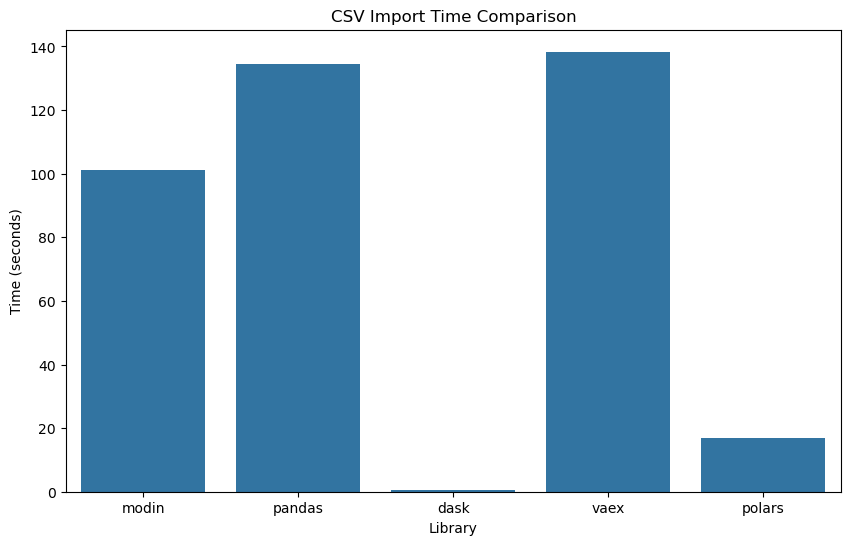

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Library', y='Time (seconds)')
plt.title('CSV Import Time Comparison')
plt.ylabel('Time (seconds)')
plt.show()